In [1]:
from SimPEG import Mesh, Directives, Maps, InvProblem, Optimization, DataMisfit, Inversion, Utils, Regularization, mkvc
import SimPEG.PF as PF
import numpy as np
from scipy import sparse as sp
import SimPEG.PF as PF
%pylab inline

Efficiency Warning: Interpolation will be slow, use setup.py!

            python setup.py build_ext --inplace
    
Populating the interactive namespace from numpy and matplotlib


In [2]:
# # STEP 1: Setup and data simulation # #
    
# Magnetic inducing field parameter (A,I,D)
B = [50000, 90, 0]

# Create a mesh
dx = 5.

hxind = [(dx, 5, -1.3), (dx, 21), (dx, 5, 1.3)]
hyind = [(dx, 5, -1.3), (dx, 15), (dx, 5, 1.3)]
hzind = [(dx, 5, -1.3), (dx, 7)]

mesh = Mesh.TensorMesh([hxind, hyind, hzind], 'CC0')
mesh.x0[2] -= mesh.vectorNz[-1]

# Get index of the center
midx = int(mesh.nCx/2)
midy = int(mesh.nCy/2)

# Lets create a simple flat topo and set the active cells
[xx, yy] = np.meshgrid(mesh.vectorNx, mesh.vectorNy)
zz = np.ones_like(xx)*mesh.vectorNz[-1]
topo = np.c_[Utils.mkvc(xx), Utils.mkvc(yy), Utils.mkvc(zz)]

# Go from topo to actv cells
actv = Utils.surface2ind_topo(mesh, topo, 'N')
actv = np.asarray([inds for inds, elem in enumerate(actv, 1) if elem],
                  dtype=int) - 1

# Create active map to go from reduce space to full
actvMap = Maps.InjectActiveCells(mesh, actv, -100)
nC = int(len(actv))

# We can now create a susceptibility model and generate data
# Here a simple block in half-space
blk_X = [-9+ midx,midx,9+ midx]
blk_Z = [-6, -5, -4]
blk_A = [0.05, 0.05, 0.05]
blk_I = [-90, 90, 0]
blk_D = [270, 270, 90]

mA = np.zeros((mesh.nCx, mesh.nCy, mesh.nCz))
mI = np.zeros((mesh.nCx, mesh.nCy, mesh.nCz))
mD = np.zeros((mesh.nCx, mesh.nCy, mesh.nCz))

for ii in range(len(blk_X)):
    mA[(blk_X[ii]-1):(blk_X[ii]+2), (midy-1):(midy+2), (blk_Z[ii]-1):(blk_Z[ii]+2)] = blk_A[ii]
    mI[(blk_X[ii]-1):(blk_X[ii]+2), (midy-1):(midy+2), (blk_Z[ii]-1):(blk_Z[ii]+2)] = blk_I[ii]
    mD[(blk_X[ii]-1):(blk_X[ii]+2), (midy-1):(midy+2), (blk_Z[ii]-1):(blk_Z[ii]+2)] = blk_D[ii]
    

mA = Utils.mkvc(mA)
mA = mA[actv]

# We create a magnetization model different than the inducing field
# to simulate remanent magnetization. Let's do something simple,
# reversely magnetized [45,90]
M = PF.Magnetics.dipazm_2_xyz(mkvc(mI)[actv], mkvc(mD)[actv])

# Multiply the orientation with the effective susceptibility
# and reshape as [mx,my,mz] vector
m = mkvc(sp.diags(mA, 0) * M)


(<matplotlib.axes._subplots.AxesSubplot at 0xc375fd0>,
 <matplotlib.contour.QuadContourSet at 0xcb65550>)

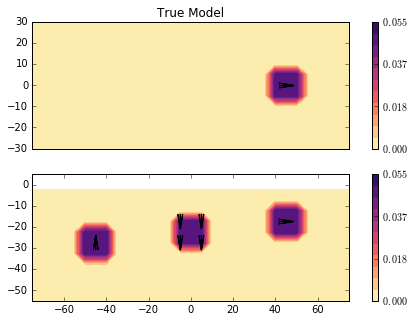

In [13]:
# plot true model
plt.figure(figsize(8, 5))
ax3 = plt.subplot(211)
PF.Magnetics.plotModelSections(mesh, m, normal='z', ind=-3, subFact=2, scale=0.25, xlim=[-75, 75], ylim=[-30, 30],
                      title="True Model", axs=ax3, vmin=0, vmax=0.065)
ax3.xaxis.set_visible(False)

ax2 = plt.subplot(212)
PF.Magnetics.plotModelSections(mesh, m, normal='y', ind=midy, subFact=2, scale=0.25, xlim=[-75, 75], ylim=[-55, 5],
                      axs=ax2, vmin=0, vmax=0.065)

In [14]:
# Create and array of observation points
xr = np.linspace(-75., 75., 20)
yr = np.linspace(-25., 25., 20)
X, Y = np.meshgrid(xr, yr)

# Move the observation points 5m above the topo
Z = np.ones_like(X) * mesh.vectorNz[-1] + dx

# Create a MAGsurvey
rxLoc = np.c_[Utils.mkvc(X.T), Utils.mkvc(Y.T), Utils.mkvc(Z.T)]
rxObj = PF.BaseMag.RxObs(rxLoc)
srcField = PF.BaseMag.SrcField([rxObj], param=(B[0], B[1], B[2]))
survey = PF.BaseMag.LinearSurvey(srcField)

In [15]:
# Create active map to go from reduce set to full
actvMap = Maps.InjectActiveCells(mesh, actv, -100)

# Create reduced identity map
idenMap = Maps.IdentityMap(nP=3*nC)

# Create the forward model operator
prob = PF.Magnetics.MagneticVector(mesh, chiMap=idenMap,
                                   actInd=actv)

# Pair the survey and problem
survey.pair(prob)

# Compute forward model some data
d = prob.fields(m)

# Add noise and uncertainties
# We add some random Gaussian noise (1nT)
d_TMI = d + np.random.randn(len(d))*0.
wd = np.ones(len(d_TMI))  # Assign flat uncertainties
survey.dobs = d_TMI
survey.std = wd


Begin calculation of forward operator: xyz
Done 0.0 %
Done 10.0 %
Done 20.0 %
Done 30.0 %
Done 40.0 %
Done 50.0 %
Done 60.0 %
Done 70.0 %
Done 80.0 %
Done 90.0 %
Done 100% ...forward operator completed!!



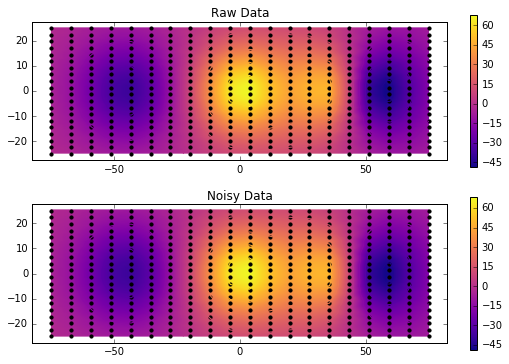

In [16]:
# Plot the data
fig = plt.figure(figsize=(8, 6))
ax1 = plt.subplot(211)
ax2 = plt.subplot(212)
out = PF.Magnetics.plot_obs_2D(rxLoc, d=d, fig=fig, ax=ax1,
                         varstr='Raw Data')
out = PF.Magnetics.plot_obs_2D(rxLoc, d=d_TMI, fig=fig, ax=ax2,
                         varstr='Noisy Data')


In [17]:
# For comparison, let's run the inversion assuming an induced response
Mind = PF.Magnetics.dipazm_2_xyz(np.ones(nC) * B[1], np.ones(nC) * B[2])

# Create a simple mag problem
# Create reduced identity map
idenMap = Maps.IdentityMap(nP=nC)
prob = PF.Magnetics.MagneticIntegral(mesh, chiMap=idenMap, actInd=actv)
survey.pair(prob)

# Create a regularization function, in this case l2l2
wr = np.sum(prob.G**2., axis=0)**0.5
wr = (wr/np.max(wr))

# Create a regularization
reg_Susc = Regularization.Sparse(mesh, indActive=actv, mapping=idenMap)
reg_Susc.cell_weights = wr

# Data misfit function
dmis = DataMisfit.l2_DataMisfit(survey)
dmis.Wd = 1/wd

# Add directives to the inversion
opt = Optimization.ProjectedGNCG(maxIter=20, lower=0., upper=1.,
                                 maxIterLS=20, maxIterCG=10, tolCG=1e-3)
invProb = InvProblem.BaseInvProblem(dmis, reg_Susc, opt)
betaest = Directives.BetaEstimate_ByEig()

# Here is where the norms are applied
# Use pick a treshold parameter empirically based on the distribution of
#  model parameters
IRLS = Directives.Update_IRLS(norms=([2, 2, 2, 2]),
                              f_min_change=1e-3, minGNiter=3)
update_Jacobi = Directives.Update_lin_PreCond()
inv = Inversion.BaseInversion(invProb,
                              directiveList=[IRLS, betaest, update_Jacobi])

# Run the inversion
m0 = np.ones(nC)*1e-4  # Starting model
mrec = inv.run(m0)

Begin calculation of forward operator: ind
Done 0.0 %
Done 10.0 %
Done 20.0 %
Done 30.0 %
Done 40.0 %
Done 50.0 %
Done 60.0 %
Done 70.0 %
Done 80.0 %
Done 90.0 %
Done 100% ...forward operator completed!!

SimPEG.InvProblem will set Regularization.mref to m0.
SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  7.23e+09  1.33e+05  0.00e+00  1.33e+05    6.54e+01      0              
   1  3.62e+09  1.18e+05  9.91e-07  1.21e+05    6.53e+01      0              
   2  1.81e+09  1.08e+05  2.91e-06  1.13e+05    6.56e+01      0   Skip BFGS  
   3  9.04e+08  9.60e+04  7.87e-06  1.03e+05    6.60e+01      0   Skip BFGS  
   4  

(<matplotlib.axes._subplots.AxesSubplot at 0xd732d30>,
 <matplotlib.contour.QuadContourSet at 0xf150860>)

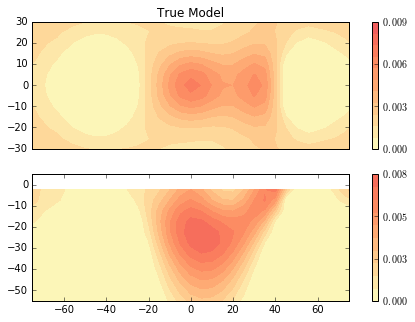

In [19]:
plt.figure(figsize(8, 5))
ax3 = plt.subplot(211)
PF.Magnetics.plotModelSections(mesh, mrec, normal='z', ind=-3, subFact=2, scale=0.25, xlim=[-75, 75], ylim=[-30, 30],
                      title="Susceptibility Model", axs=ax3, vmin=0, vmax=0.025)
ax3.xaxis.set_visible(False)

ax2 = plt.subplot(212)
PF.Magnetics.plotModelSections(mesh, mrec, normal='y', ind=midy, subFact=2, scale=0.25, xlim=[-75, 75], ylim=[-55, 5],
                      axs=ax2, vmin=0, vmax=0.025)

In [42]:
# %% STEP 1: EQUIVALENT SOURCE LAYER
# The first step inverts for an equiavlent source layer in order to convert the
# observed TMI data to magnetic field Amplitude.

# Get the active cells for equivalent source is the top only
surf = PF.MagneticsDriver.actIndFull2layer(mesh, actv)

# Get the layer of cells directyl below topo
#surf = Utils.actIndFull2layer(mesh, active)
nC = len(surf)  # Number of active cells

# Create active map to go from reduce set to full
surfMap = Maps.InjectActiveCells(mesh, surf, -100)

# Create identity map
idenMap = Maps.IdentityMap(nP=nC)

# Create static map
prob = PF.Magnetics.MagneticIntegral(mesh, chiMap = idenMap, actInd=surf, equiSourceLayer = True)
prob.solverOpts['accuracyTol'] = 1e-4

# Pair the survey and problem
survey.pair(prob)

# Create a regularization function, in this case l2l2
reg = Regularization.Simple(mesh, indActive=surf)
reg.mref = np.zeros(nC)

# Specify how the optimization will proceed, set susceptibility bounds to inf
opt = Optimization.ProjectedGNCG(maxIter=150, lower=-np.inf,
                                 upper=np.inf, maxIterLS=20,
                                 maxIterCG=20, tolCG=1e-3)

# Define misfit function (obs-calc)
dmis = DataMisfit.l2_DataMisfit(survey)
dmis.Wd = 1./survey.std

# Create the default L2 inverse problem from the above objects
invProb = InvProblem.BaseInvProblem(dmis, reg, opt)

# Specify how the initial beta is found
betaest = Directives.BetaEstimate_ByEig()

# Beta schedule for inversion
betaSchedule = Directives.BetaSchedule(coolingFactor = 2., coolingRate = 1)

# Target misfit to stop the inversion,
# try to fit as much as possible of the signal, we don't want to lose anything
targetMisfit = Directives.TargetMisfit(chifact = 0.1)

# Put all the parts together
inv = Inversion.BaseInversion(invProb,
                              directiveList=[betaest, betaSchedule, targetMisfit])

# Run the equivalent source inversion
mstart = np.zeros(nC)
mrec = inv.run(mstart)

#%% STEP 2: COMPUTE AMPLITUDE DATA
# Now that we have an equialent source layer, we can forward model alh three
# components of the field and add them up: |B| = ( Bx**2 + Bx**2 + Bx**2 )**0.5

# Won't store the sensitivity and output 'xyz' data.
prob.forwardOnly=True
prob.rtype='xyz'
pred = prob.Intrgl_Fwr_Op(m=mrec)

ndata = survey.nD

damp = np.sqrt(pred[:ndata]**2. +
                       pred[ndata:2*ndata]**2. +
                       pred[2*ndata:]**2.)

SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using same Solver and solverOpts as the problem***
Begin calculation of forward operator: ind
Done 0.0 %
Done 10.0 %
Done 20.0 %
Done 30.0 %
Done 40.0 %
Done 50.0 %
Done 60.0 %
Done 70.0 %
Done 80.0 %
Done 90.0 %
Done 100% ...forward operator completed!!

model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.12e+10  1.33e+05  0.00e+00  1.33e+05    1.03e+07      0              
   1  5.62e+09  1.25e+05  3.44e-07  1.27e+05    5.00e+06      0              
   2  2.81e+09  1.18e+05  1.29e-06  1.22e+05    4.84e+06      0   Skip BFGS  
   3  1.41e+09  1.06e+05  4.56e-06  1.12e+05    4.55e+06      0   Skip BFGS  
   4  7.03e+08  8.67e+04  1.46e-05  9.70e+04    4.08e+06    

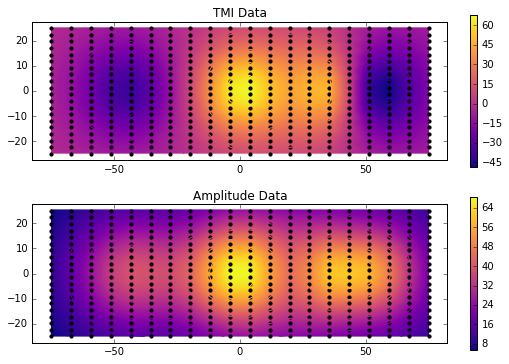

In [43]:
# Plot the data
fig = plt.figure(figsize=(8, 6))
ax1 = plt.subplot(211)
ax2 = plt.subplot(212)
out = PF.Magnetics.plot_obs_2D(rxLoc, d=d_TMI, fig=fig, ax=ax1,
                         varstr='TMI Data')
out = PF.Magnetics.plot_obs_2D(rxLoc, d=damp, fig=fig, ax=ax2,
                         varstr='Amplitude Data')

In [84]:
#%% STEP 3: RUN AMPLITUDE INVERSION
# Now that we have |B| data, we can invert. This is a non-linear inversion,
# which requires some special care for the sensitivity weights (see Directives)

# Create active map to go from reduce space to full
actvMap = Maps.InjectActiveCells(mesh, actv, -100)
nC = len(actv)

# Create identity map
idenMap = Maps.IdentityMap(nP=nC)

mstart= np.ones(len(actv))*1e-4

# Create the forward model operator
prob = PF.Magnetics.MagneticAmplitude(mesh, chiMap=idenMap,
                                     actInd=actv)
prob.chi = mstart

# Change the survey to xyz components
survey_xyz = PF.BaseMag.LinearSurvey(srcField)
survey_xyz.srcField.rxList[0].rxType = 'xyz'

# Pair the survey and problem
survey_xyz.pair(prob)

# Re-set the observations to |B|
survey_xyz.dobs = damp

# Create a sparse regularization
reg = Regularization.Sparse(mesh, indActive=actv, mapping=idenMap)
reg.mref = np.zeros(nC)

# Data misfit function
dmis = DataMisfit.l2_DataMisfit(survey_xyz)
dmis.Wd = 1/survey.std

# Add directives to the inversion
opt = Optimization.ProjectedGNCG(maxIter=100, lower=0., upper=1.,
                                 maxIterLS=20, maxIterCG=10,
                                 tolCG=1e-3)

invProb = InvProblem.BaseInvProblem(dmis, reg, opt)

# Here is the list of directives
betaest = Directives.BetaEstimate_ByEig()

# Specify the sparse norms
IRLS = Directives.Update_IRLS(norms=([2, 2, 2, 2]),
                              eps=None, f_min_change=1e-3,
                              minGNiter=3, coolingRate=1, chifact = 0.25)

# Special directive specific to the mag amplitude problem. The sensitivity
# weights are update between each iteration.
update_Jacobi = Directives.Amplitude_Inv_Iter()

# Put all together
inv = Inversion.BaseInversion(invProb,
                                   directiveList=[update_Jacobi,IRLS,betaest])

# Invert
mrec_Amp = inv.run(mstart)

SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using same Solver and solverOpts as the problem***
Begin calculation of forward operator: ind
Done 0.0 %
Done 10.0 %
Done 20.0 %
Done 30.0 %
Done 40.0 %
Done 50.0 %
Done 60.0 %
Done 70.0 %
Done 80.0 %
Done 90.0 %
Done 100% ...forward operator completed!!

model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  7.47e+09  2.27e+05  2.20e-06  2.44e+05    6.88e+01      0              
   1  3.73e+09  1.94e+05  3.98e-06  2.09e+05    7.37e+01      0              
   2  1.87e+09  1.54e+05  1.21e-05  1.76e+05    7.47e+01      0   Skip BFGS  
   3  9.33e+08  1.13e+05  3.11e-05  1.43e+05    7.47e+01      0   Skip BFGS  
   4  4.67e+08  7.35e+04  6.39e-05  1.03e+05    7.42e+01    

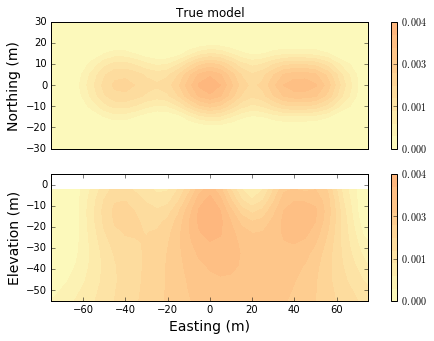

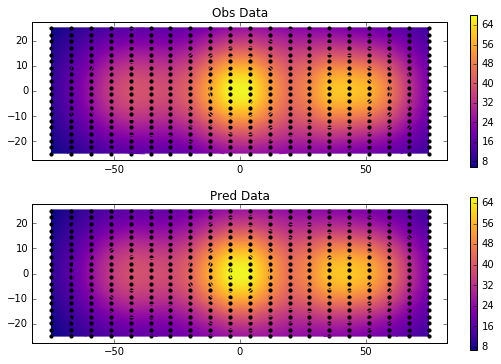

In [85]:
plotModel(mesh, mrec_Amp, midy, -3, vmin=mA.min(), vmax=mA.max()*.5, vec=False, sub =2)

fig = plt.figure(figsize=(8, 6))
ax1 = plt.subplot(211)
ax2 = plt.subplot(212)
out = PF.Magnetics.plot_obs_2D(rxLoc, d=damp, fig=fig, ax=ax1,
                         varstr='Obs Data')
out = PF.Magnetics.plot_obs_2D(rxLoc, d=invProb.dpred, fig=fig, ax=ax2,
                         varstr='Pred Data')

In [81]:
# # STEP 2: Invert for a magnetization model in Cartesian space # #
# Create the forward model operator
idenMap = Maps.IdentityMap(nP=3*nC)
prob = PF.Magnetics.MagneticVector(mesh, chiMap=idenMap,
                                     actInd=actv)

# Explicitely set starting model
prob.chi = mstart

# Pair the survey and problem
survey = PF.BaseMag.LinearSurvey(srcField)
survey.srcField.rxList[0].rxType = 'tmi'
survey.dobs = d_TMI
survey.std = wd

survey.pair(prob)

# Create a static sensitivity weighting function
wr = np.sum(prob.G**2., axis=0)**0.5
wr = (wr/np.max(wr))

# Create a block diagonal regularization
reg = Regularization.Sparse(mesh, indActive=actv, mapping=idenMap,
                            nSpace=3)
reg.cell_weights = wr
reg.mref = np.zeros(3*nC)

# Data misfit function
dmis = DataMisfit.l2_DataMisfit(survey)
dmis.Wd = 1./survey.std

# Add directives to the inversion
opt = Optimization.ProjectedGNCG(maxIter=10, lower=-10., upper=10.,
                                 maxIterCG=20, tolCG=1e-3)

invProb = InvProblem.BaseInvProblem(dmis, reg, opt)
betaest = Directives.BetaEstimate_ByEig()

# Here is where the norms are applied
IRLS = Directives.Update_IRLS(norms=([2, 2, 2, 2]),
                              eps=None, f_min_change=1e-4,
                              minGNiter=3, beta_tol=1e-2)

update_Jacobi = Directives.Update_lin_PreCond()

inv = Inversion.BaseInversion(invProb,
                              directiveList=[update_Jacobi, IRLS, betaest])

mstart = np.ones(3*nC)*1e-4
mrec_C = inv.run(mstart)

Begin calculation of forward operator: xyz
Done 0.0 %
Done 10.0 %
Done 20.0 %
Done 30.0 %
Done 40.0 %
Done 50.0 %
Done 60.0 %
Done 70.0 %
Done 80.0 %
Done 90.0 %
Done 100% ...forward operator completed!!

SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  2.88e+09  1.33e+05  5.52e-06  1.49e+05    1.67e+03      0              
   1  1.44e+09  7.59e+04  1.07e-05  9.13e+04    1.67e+03      0              
   2  7.21e+08  4.51e+04  2.08e-05  6.01e+04    1.66e+03      0   Skip BFGS  
   3  3.60e+08  2.56e+04  3.99e-05  4.00e+04    1.66e+03      0   Skip BFGS  
   4  1.80e+08  1.27e+04  6.50e-05  2.45e+04    1.65e+03    

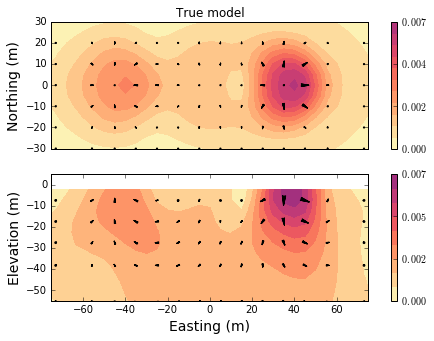

In [25]:
plotModel(mesh, mrec_C, midy, -3, vmin=mA.min(), vmax=mA.max()*.25, sub =2, scale=0.05)

In [82]:
# Create rescaled weigths
mamp = (mrec_Amp/mrec_Amp.max() + 1e-2)**-1.

# Update the sensitivity weights with amplitude weights added
reg = Regularization.Sparse(mesh, indActive=actv, mapping=idenMap, nSpace=3)
wr = np.sum(prob.G**2., axis=0)**0.5
wr = (wr/np.max(wr))*np.r_[mamp, mamp, mamp]
reg.cell_weights = wr

# Data misfit function
dmis = DataMisfit.l2_DataMisfit(survey)
dmis.Wd = 1./survey.std

# Add directives to the inversion
opt = Optimization.ProjectedGNCG(maxIter=30, lower=-10., upper=10.,
                                 maxIterCG=20, tolCG=1e-3)

invProb = InvProblem.BaseInvProblem(dmis, reg, opt)
betaest = Directives.BetaEstimate_ByEig()

betaCool = Directives.BetaSchedule(coolingFactor=2., coolingRate=1)

update_Jacobi = Directives.Update_lin_PreCond()
targetMisfit = Directives.TargetMisfit()

inv = Inversion.BaseInversion(invProb,
                              directiveList=[betaest, update_Jacobi, betaCool, targetMisfit])

mrec_CMI = inv.run(mstart)

M_CMI = mrec_CMI.reshape(nC,3)
amp = np.sum(M_CMI**2., axis=1)**0.5
m_CMI = sp.diags(amp**-1.,0) * M_CMI



SimPEG.InvProblem will set Regularization.mref to m0.
SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  6.16e+07  1.33e+05  0.00e+00  1.33e+05    1.67e+03      0              
   1  3.08e+07  3.92e+04  4.71e-04  5.37e+04    1.67e+03      0              
   2  1.54e+07  2.27e+04  8.51e-04  3.58e+04    1.67e+03      0   Skip BFGS  
   3  7.70e+06  1.20e+04  1.34e-03  2.23e+04    1.66e+03      0   Skip BFGS  
   4  3.85e+06  5.84e+03  1.89e-03  1.31e+04    1.65e+03      0   Skip BFGS  
   5  1.92e+06  2.59e+03  2.48e-03  7.36e+03    1.64e+03      0   Skip BFGS  
   6  9.62e+05  1.05e+03  3.03e-03  3.96e+03    1.61e+0

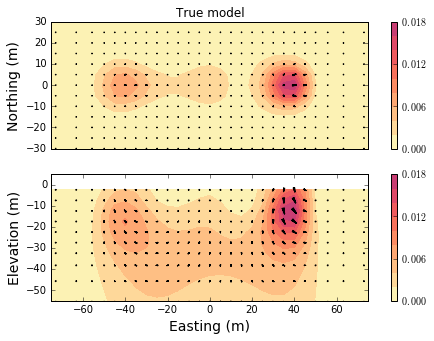

In [27]:
plotModel(mesh, mrec_CMI, midy, -3, vmin=mA.min(), vmax=mA.max()*.75, sub =1, scale=0.2)

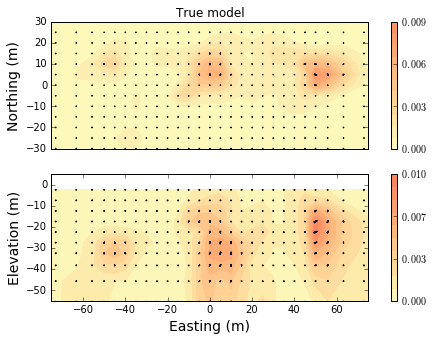

In [83]:
plotModel(mesh, mrec_CMI, midy, -3, vmin=mA.min(), vmax=mA.max()*.75, sub =1, scale=0.2)

array([ 0.61494438,  0.58991409,  0.52330179])